# Importing libraries

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from keras.layers import Input, Lambda, Dense , Flatten , AveragePooling2D, MaxPooling2D, Conv2D
from keras.models import Model, Sequential 
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.preprocessing import image 

import keras.backend as K 
import numpy as np 
import matplotlib.pyplot as plt 
from keras.utils import load_img , img_to_array



from scipy.optimize import fmin_l_bfgs_b

# Content

In [ ]:
#Recreate VGG model with average pooling instead of max pooling 
def VGG16_AVG_pool(shape): 
    vgg= VGG16(input_shape=shape, weights="imagenet", include_top=False)

    new_model=Sequential()
    new_model.add(Input(shape))
    for layer in vgg.layers: 
        if layer.__class__==MaxPooling2D : 
            new_model.add(AveragePooling2D())
        else : 
            new_model.add(layer)
    return new_model 

In [ ]:
#Create a partial model with the number of convolutions we want 
def VGG16_AvgPool_CutOff(shape, num_convs): 
    if num_convs<1 or num_convs>13 : 
        print("num_convs must be in the range [1,13]")
        return None 

    model = VGG16_AVG_pool(shape)
    new_model = Sequential( )
    n=0 
    for layer in model.layers : 
        if layer.__class__== Conv2D :
            n+=1 
        new_model.add(layer)
        if n >=num_convs : 
            break 
    return new_model


In [ ]:
#Does the reverse of VGG preprocess function 
def unpreprocess(img): 
    img[..., 0] +=103.939
    img[...,1] +=116.779
    img[...,2] +=126.68
    img=img[..., ::-1]
    return img 


def scale_img(x):
    x=x-x.min()
    x=x/x.max()
    return x 

# Loading the image 

In [ ]:
path ="content1.jpg"
img=load_img(path)

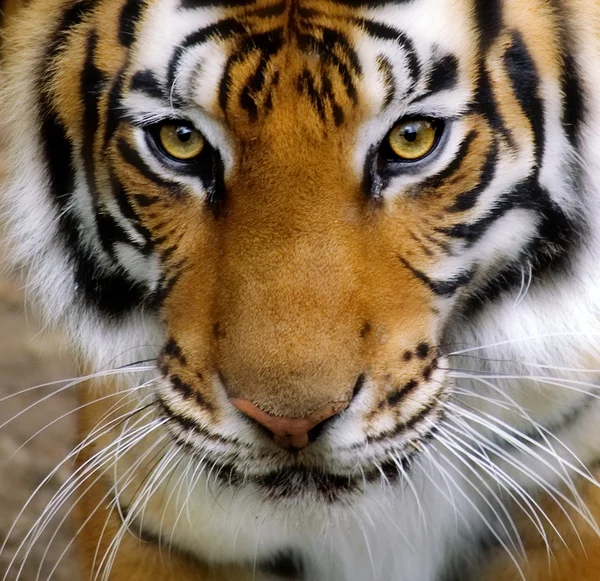

In [ ]:
img

# Main 

In [ ]:
x=img_to_array(img)
x.shape

(581, 600, 3)

In [ ]:
x=np.expand_dims(x, axis=0)
x=preprocess_input(x)

In [ ]:
#Config : 
batch_shape = x.shape
shape =x.shape[1:]


content_model =VGG16_AvgPool_CutOff(shape,11)
target=K.variable(content_model.predict(x))#Model output given X

loss= K.mean(K.square(target - content_model.output))#MSE between the symbolic content model output and the target 

grads =K.gradients(loss, content_model.input)

get_loss_and_grads = K.function(
    inputs= [content_model.input], 
    outputs=[loss] + grads 
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
content_model.output

<tf.Tensor 'block5_conv1_33/Relu:0' shape=(None, 36, 37, 512) dtype=float32>

In [ ]:
def get_loss_and_grads_wrapper(x_vec): 
    #scipy's minimizer allows us to pass back function value f(x) and its gradient f'(x)
    #simultaneously, rather than using the fprime arg 
    #We cannot use get_loss_and_grads() directly 
    #input to minimizer func must be a 1-D array 
    #input to get_loss_and_grads must be [batch_of_images]

    l,g= get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=80.03909301757812
iter=1, loss=41.76875686645508
iter=2, loss=26.970788955688477
iter=3, loss=19.6252384185791
iter=4, loss=15.113723754882812
iter=5, loss=12.260416984558105
iter=6, loss=10.192878723144531
iter=7, loss=8.687135696411133
iter=8, loss=7.661319255828857
iter=9, loss=6.944663047790527
iter=10, loss=6.292889595031738
iter=11, loss=5.819608211517334
iter=12, loss=5.690227508544922
iter=13, loss=5.0676374435424805
iter=14, loss=4.931190013885498
iter=15, loss=4.605398178100586
iter=16, loss=4.525286674499512
iter=17, loss=4.524839878082275
iter=18, loss=4.525888919830322
iter=19, loss=4.525888919830322
Duration: 0:01:50.883064


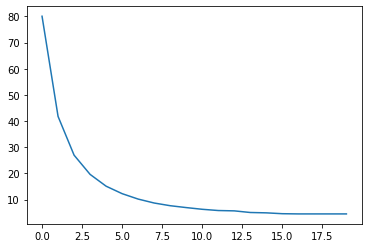

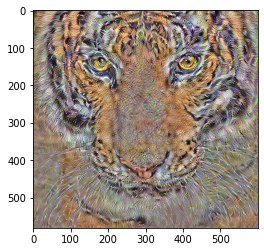

In [ ]:
from datetime import datetime
t0 = datetime.now()
losses=[]

x=np.random.randn(np.prod(batch_shape))
for i in range(20): 
    x,l, _=fmin_l_bfgs_b(
        func=get_loss_and_grads_wrapper, 
        x0 = x, 
        maxfun = 20
    )
    x = np.clip(x, -127, 127)
    print("iter=%s, loss=%s" % (i,l))

    losses.append(l)
print("Duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

newimg=x.reshape(*batch_shape)
final_img = unpreprocess(newimg)

plt.imshow(scale_img(final_img[0]))
plt.show()




# Recreating style 

In [ ]:
def gram_matrix(img): 
    #input is (H,W,C) (C = # feature maps)
    #we first need to convert it to (C, H*W)
    X=K.batch_flatten(K.permute_dimensions(img,(2,0,1)))

    #now, calculate the gram matrix
    # gram=XX^T/N
    # the constant is not important since we(ll be weighting these) 
    G=K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return G

def style_loss(y,t): 
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

def minimize(fn, epochs, batch_shape): 
    t0 = datetime.now()
    losses= []
    x=np.random.randn(np.prod(batch_shape))

    for i in range(epochs) :
        x,l ,_ =fmin_l_bfgs_b(
            func=fn,
            x0=x,
            maxfun=20
        )
        x=np.clip(x, -127, 127)
        print("iter=%s , loss=%s" % (i,l))
        losses.append(l)

    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg=x.reshape(*batch_shape)
    final_img=unpreprocess(newimg)
    return final_img[0]




# Main

## For the first image 

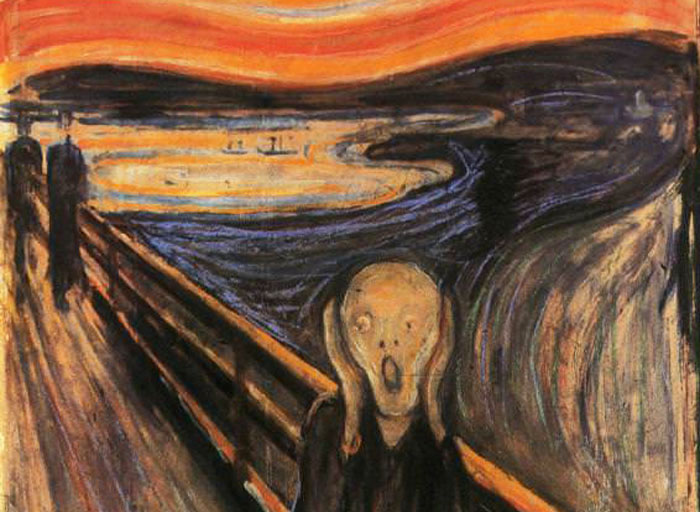

In [ ]:
path="style1.jpg"

img= load_img(path)
img

In [ ]:
x = img_to_array(img)
x=np.expand_dims(x,axis=0)
x.shape

(1, 512, 700, 3)

In [ ]:
x = preprocess_input(x)
batch_shape=x.shape
shape=x.shape[1:]

vgg = VGG16_AVG_pool(shape)

symbolic_conv_outputs=[
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")
]

#pick the earlier layers for a more "localized" representation 
#this is opposed to the content model where the later layers represent a more "global" structure 
#symbolic_conv_outputs= symbolic_conv_outputs[:2]

#make a big model that outputs multiple layers' outputs :
multi_output_model = Model(vgg.input, symbolic_conv_outputs)
style_layers_outputs= [K.variable(y) for y in multi_output_model.predict(x)]

multi_output_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 512, 700, 3)]     0         
                                                                 
 input_23 (InputLayer)       multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 700, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 700, 64)      36928     
                                                                 
 average_pooling2d_55 (Avera  (None, 256, 350, 64)     0         
 gePooling2D)                                                    
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 350, 128)     73856     
                                                           

In [ ]:
multi_output_model.output

[<tf.Tensor 'block1_conv1_25/Relu:0' shape=(None, 512, 700, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_25/Relu:0' shape=(None, 256, 350, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1_25/Relu:0' shape=(None, 128, 175, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1_25/Relu:0' shape=(None, 64, 87, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1_25/Relu:0' shape=(None, 32, 43, 512) dtype=float32>]

In [ ]:
style_layers_outputs

[<tf.Variable 'Variable_32:0' shape=(1, 512, 700, 64) dtype=float32>,
 <tf.Variable 'Variable_33:0' shape=(1, 256, 350, 128) dtype=float32>,
 <tf.Variable 'Variable_34:0' shape=(1, 128, 175, 256) dtype=float32>,
 <tf.Variable 'Variable_35:0' shape=(1, 64, 87, 512) dtype=float32>,
 <tf.Variable 'Variable_36:0' shape=(1, 32, 43, 512) dtype=float32>]

In [ ]:
loss= 0 
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs) :
    #gram_matrix expect a (H,W,C) as input 
    loss+= style_loss(symbolic[0], actual[0])

grads= K.gradients(loss, multi_output_model.input)

get_loss_and_grads = K.function(
    inputs= [multi_output_model.input], 
    outputs=[loss] + grads
)



In [ ]:
def get_loss_and_grad_wrapper(x_vec) :
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0 , loss=6628.63037109375
iter=1 , loss=1432.302490234375
iter=2 , loss=695.7001953125
iter=3 , loss=405.1838684082031
iter=4 , loss=259.8648681640625
iter=5 , loss=175.44677734375
iter=6 , loss=107.7175064086914
iter=7 , loss=68.35979461669922
iter=8 , loss=41.31540298461914
iter=9 , loss=28.26101303100586
duration: 0:01:13.015075


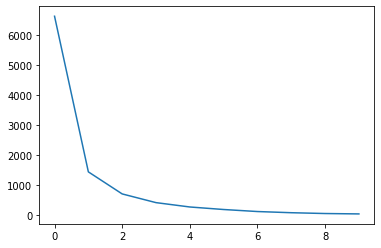

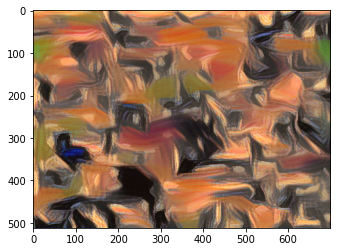

In [ ]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

## For the second image 

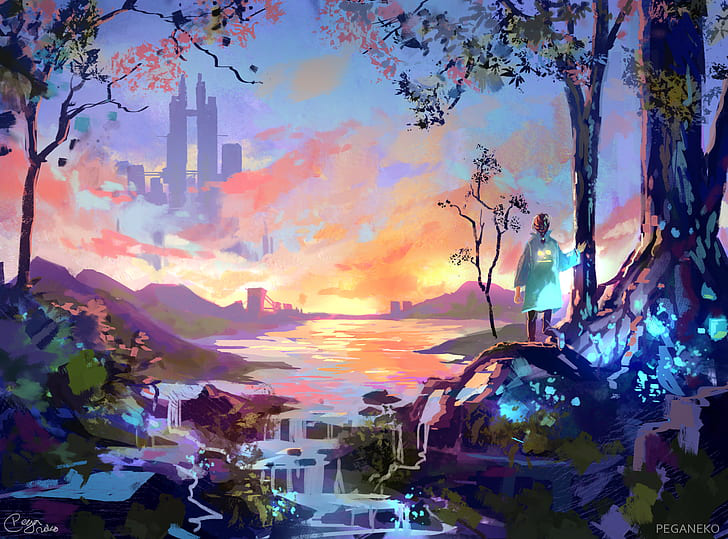

In [ ]:
path="style2.jpg"

img= load_img(path)
img

In [ ]:
x = img_to_array(img)
x=np.expand_dims(x,axis=0)
x.shape

(1, 539, 728, 3)

In [ ]:
x = preprocess_input(x)
batch_shape=x.shape
shape=x.shape[1:]

vgg = VGG16_AVG_pool(shape)

symbolic_conv_outputs=[
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")
]

#pick the earlier layers for a more "localized" representation 
#this is opposed to the content model where the later layers represent a more "global" structure 
#symbolic_conv_outputs= symbolic_conv_outputs[:2]

#make a big model that outputs multiple layers' outputs :
multi_output_model = Model(vgg.input, symbolic_conv_outputs)
style_layers_outputs= [K.variable(y) for y in multi_output_model.predict(x)]

multi_output_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 539, 728, 3)]     0         
                                                                 
 input_17 (InputLayer)       multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 539, 728, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 539, 728, 64)      36928     
                                                                 
 average_pooling2d_40 (Avera  (None, 269, 364, 64)     0         
 gePooling2D)                                                    
                                                                 
 block2_conv1 (Conv2D)       (None, 269, 364, 128)     73856     
                                                           

In [ ]:
loss= 0 
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs) :
    #gram_matrix expect a (H,W,C) as input 
    loss+= style_loss(symbolic[0], actual[0])

grads= K.gradients(loss, multi_output_model.input)

get_loss_and_grads = K.function(
    inputs= [multi_output_model.input], 
    outputs=[loss] + grads
)



In [ ]:
def get_loss_and_grad_wrapper(x_vec) :
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0 , loss=22581.955078125
iter=1 , loss=2848.516845703125
iter=2 , loss=1440.5281982421875
iter=3 , loss=952.6226806640625
iter=4 , loss=676.2343139648438
iter=5 , loss=491.4645080566406
iter=6 , loss=345.8826599121094
iter=7 , loss=255.65037536621094
iter=8 , loss=199.87109375
iter=9 , loss=151.4810028076172
duration: 0:01:20.821329


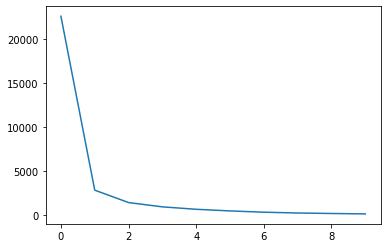

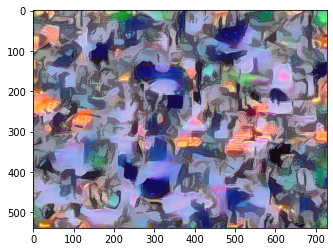

In [ ]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

## For the third image 

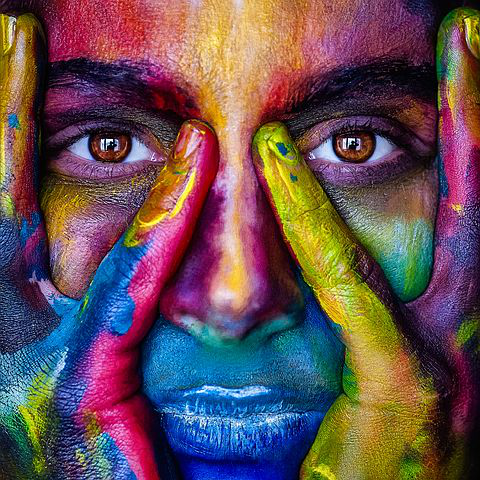

In [ ]:
path="style3.jpg"

img= load_img(path)
img

In [ ]:
x = img_to_array(img)
x=np.expand_dims(x,axis=0)
x.shape

(1, 480, 480, 3)

In [ ]:
x = preprocess_input(x)
batch_shape=x.shape
shape=x.shape[1:]

vgg = VGG16_AVG_pool(shape)

symbolic_conv_outputs=[
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")
]

#pick the earlier layers for a more "localized" representation 
#this is opposed to the content model where the later layers represent a more "global" structure 
#symbolic_conv_outputs= symbolic_conv_outputs[:2]

#make a big model that outputs multiple layers' outputs :
multi_output_model = Model(vgg.input, symbolic_conv_outputs)
style_layers_outputs= [K.variable(y) for y in multi_output_model.predict(x)]

multi_output_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 480, 480, 3)]     0         
                                                                 
 input_19 (InputLayer)       multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 480, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 480, 64)      36928     
                                                                 
 average_pooling2d_45 (Avera  (None, 240, 240, 64)     0         
 gePooling2D)                                                    
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 240, 128)     73856     
                                                           

In [ ]:
loss= 0 
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs) :
    #gram_matrix expect a (H,W,C) as input 
    loss+= style_loss(symbolic[0], actual[0])

grads= K.gradients(loss, multi_output_model.input)

get_loss_and_grads = K.function(
    inputs= [multi_output_model.input], 
    outputs=[loss] + grads
)



In [ ]:
def get_loss_and_grad_wrapper(x_vec) :
    l,g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0 , loss=22176.947265625
iter=1 , loss=3571.509521484375
iter=2 , loss=727.4888305664062
iter=3 , loss=345.43035888671875
iter=4 , loss=228.3516845703125
iter=5 , loss=163.74766540527344
iter=6 , loss=127.88433837890625
iter=7 , loss=104.12724304199219
iter=8 , loss=84.75361633300781
iter=9 , loss=73.05260467529297
duration: 0:00:48.969883


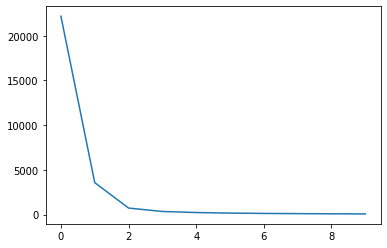

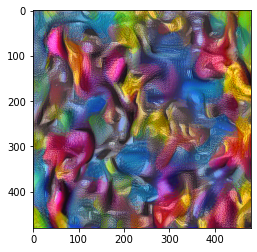

In [ ]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

# Combining the codes to get the final result

In [ ]:
def load_img_and_preprocess(path, shape=None):
    img=load_img(path, target_size=shape)
    x=img_to_array(img)
    x=np.expand_dims(x, axis=0)
    x=preprocess_input(x)
    return x 

In [ ]:
content_img= load_img_and_preprocess("content1.jpg")
h,w=content_img.shape[1:3]

style_img = load_img_and_preprocess("style1.jpg", (h,w))

batch_shape=content_img.shape
shape = content_img.shape[1:]

vgg=VGG16_AVG_pool(shape)

#create the content model 
#we only want 1 output 
#We can call vgg.summary() to see a list of layers 

#vgg.summary()


In [ ]:
vgg.layers[13].name

'block4_conv3'

In [ ]:
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
#create the style model 
#we want multiple outputs 
symbolic_conv_outputs=[
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")
]
print("Number of outputs : ",len(symbolic_conv_outputs))

#make a big model that outputs multiple layers' outputs 
style_model= Model(vgg.input, symbolic_conv_outputs)

#calculate the targets that are output at each layer 
style_layers_outputs= [K.variable(y) for y in style_model.predict(style_img)]

#we will assume the weight of the content loss is 1 and only weight the style losses 
style_weights =[1,2,3,4,5]

Number of outputs :  5


iter=0 , loss=15007.7626953125
iter=1 , loss=4334.5107421875
iter=2 , loss=2596.697509765625
iter=3 , loss=1818.51513671875
iter=4 , loss=1458.0614013671875
iter=5 , loss=1211.673583984375
iter=6 , loss=1019.0140991210938
iter=7 , loss=887.8443603515625
iter=8 , loss=779.6583862304688
iter=9 , loss=699.0919189453125
duration: 0:01:14.210483


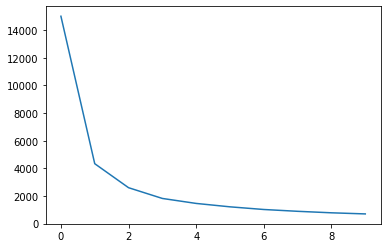

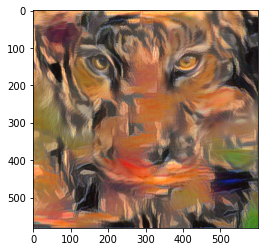

In [ ]:
#create the total loss wi=hich is the sum of content + style loss 
loss=K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs) :
    #gram_matrix() expects a (H,W,C) as input 
    loss+= w * style_loss(symbolic[0], actual[0])

# once again, create the gradients and loss + grad function 
#note : it doen't matter which model's input you use 
#they are both pointing to the same keras Input layer in memory 
grads= K.gradients(loss, vgg.input)
get_loss_and_grads= K.function(
    inputs=[vgg.input],
    outputs= [loss]+grads
)

def get_loss_and_grads_wrapper(x_vec): 
    l,g= get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

final_img=minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()

# For the second style image : 

# Combining the codes to get the final result

In [ ]:
def load_img_and_preprocess(path, shape=None):
    img=load_img(path, target_size=shape)
    x=img_to_array(img)
    x=np.expand_dims(x, axis=0)
    x=preprocess_input(x)
    return x 

In [ ]:
content_img= load_img_and_preprocess("content1.jpg")
h,w=content_img.shape[1:3]

style_img = load_img_and_preprocess("style3.jpg", (h,w))

batch_shape=content_img.shape
shape = content_img.shape[1:]

vgg=VGG16_AVG_pool(shape)

#create the content model 
#we only want 1 output 
#We can call vgg.summary() to see a list of layers 

#vgg.summary()


In [ ]:
vgg.layers[13].name

'block4_conv3'

In [ ]:
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
#create the style model 
#we want multiple outputs 
symbolic_conv_outputs=[
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith("conv1")
]
print("Number of outputs : ",len(symbolic_conv_outputs))

#make a big model that outputs multiple layers' outputs 
style_model= Model(vgg.input, symbolic_conv_outputs)

#calculate the targets that are output at each layer 
style_layers_outputs= [K.variable(y) for y in style_model.predict(style_img)]

#we will assume the weight of the content loss is 1 and only weight the style losses 
style_weights =[1,2,3,4,5]

Number of outputs :  5


iter=0 , loss=57375.09765625
iter=1 , loss=10484.974609375
iter=2 , loss=3768.94091796875
iter=3 , loss=2269.941162109375
iter=4 , loss=1763.872314453125
iter=5 , loss=1527.1219482421875
iter=6 , loss=1386.18798828125
iter=7 , loss=1269.9483642578125
iter=8 , loss=1182.045654296875
iter=9 , loss=1110.0657958984375
duration: 0:01:08.194583


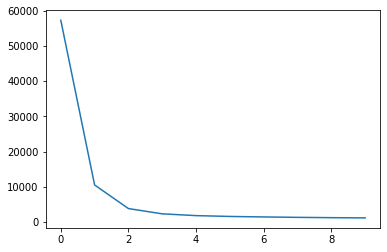

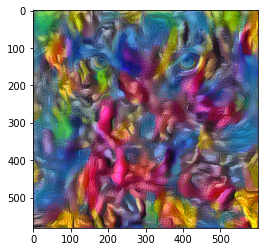

In [ ]:
#create the total loss wi=hich is the sum of content + style loss 
loss=K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs) :
    #gram_matrix() expects a (H,W,C) as input 
    loss+= w * style_loss(symbolic[0], actual[0])

# once again, create the gradients and loss + grad function 
#note : it doen't matter which model's input you use 
#they are both pointing to the same keras Input layer in memory 
grads= K.gradients(loss, vgg.input)
get_loss_and_grads= K.function(
    inputs=[vgg.input],
    outputs= [loss]+grads
)

def get_loss_and_grads_wrapper(x_vec): 
    l,g= get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

final_img=minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.show()